In [1]:
pwd()

"/Users/kyan/Projects/qgplsim"

# Start

In [365]:
# run this ceil if source codes was edited
include("DGP.ji")
# include("qgplsim.ji")
include("MonteCarloSIM.ji")
using Statistics, LinearAlgebra, Clustering
using LaTeXStrings, Plots

import Base.Threads.@threads

# QGPLSIM fitting

In [367]:
# run this ceil for different data sets

α = [1.0, 0.5] # single index for x
θ = [0.5, -1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 0.5] # single index for z
β = [0.5, 1.0] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)

n = 500
fx = 2 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 1 # 0 for gauss, 1 for Cauchy
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5

# Estimation 

model1 = qgplsim.model(X, Z, y, τ)
alpha_type = 1
# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for global: ∑ij sum(Bi - Bj) / n;
# 2 for local: ∑z ∑ij (bzi - bzj) * nz / n;
# when Z = 0, global == local
@time alpha1, gamma, theta, beta = qgplsim.estimator(model1, alpha_type)
coefa = 1 #/ alpha[1]
coefg = 1 #/ gamma[1]
println("Estimation of index coefs: ")
println("̂α => ", coefa * alpha1)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

# theta * alpha

  2.969966 seconds (2.19 M allocations: 9.801 GiB, 59.15% gc time)
Estimation of index coefs: 
̂α => [0.8639580554964036; 0.5035637778304484]
̂γ => [0.29623263609033573, 1.3752093122937812]
Estimation of linear coefs: 
̂θ => [0.5999307170994677 -1.029293604101003]
̂β => [3.0982909042810878, -0.9612314761345844]


# Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

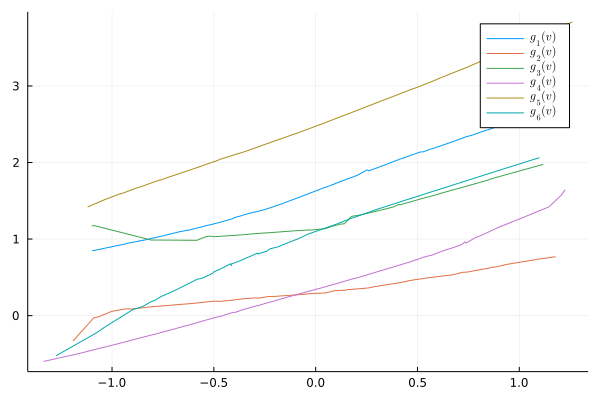

In [368]:
alphap = 1.0 * alpha1
v = X * alphap # g(Xα + Zγ) => univar func. g(v + zγ) after α was determined and  Z = z
categ, index = model1.categ, model1.index
g, dg = qgplsim.Gz_DGz(v, Z, y - X * transpose(theta), 0.5, -0.4) # g: g(v), dg: g'(v)
fig = plot()
for m in 1:6
    vm = v[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]

    plot!(fig, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")

end
fig

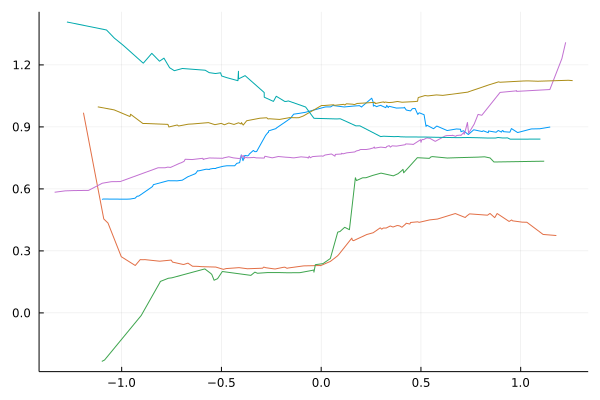

In [369]:
fig = plot()
for m in 1:6
    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_vm = vm[indm]
    plot!(fig, sorted_vm, sorted_dgm, label = false )#L"\nabla g_{%$m} (v)")

end
fig

# Monte Carlo Simulation

In [43]:
Threads.nthreads()

2

In [327]:
include("MonteCarloSIM.ji")

main (generic function with 4 methods)

In [350]:
α = [1.0, 0.5] # single index for x
θ = [1.0, -2.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0] # single index for z
β = [1.0, -0.5] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = 600
fx = 1
dist = 1 # Cauchy
rep = 20 # MC rept. times

20

In [351]:
Alpha, Gamma, Theta, Beta = MonteCarlo(n, γ, θ, α, β, fx, dist, rep)
mean(Gamma, dims = 1)

gamma = [0.6248039412755801, 1.1018489986060418]
gamma = [0.7439213626943348, 1.2075647686599815]
gamma = [0.6496778577942062, 1.6068272890653723]
gamma = [0.5558512507422323, 1.1888090508330051]
gamma = [0.9101748023382302, 1.2433453136546344]
gamma = [0.328298828352276, 1.2203529970104185]
gamma = [0.6107422110872915, 1.4663735204174726]
gamma = [0.6444208279714577, 1.2684873186230667]
gamma = [0.6409646142710599, 1.2035059907089833]
gamma = [0.4557781452667075, 1.3468027969533212]
gamma = [1.0877499316610173, 1.2653856308589424]
gamma = [0.8124620741761004, 1.5145850410907828]
gamma = [0.5514067925859539, 1.2807337144932556]
gamma = [0.8372414615900308, 1.3248579365512283]
gamma = [0.5518146205478642, 1.1924881192314913]
gamma = [0.6985157754438804, 1.2992056794848086]
gamma = [0.642964561030296, 1.1181407039383133]
gamma = [0.5426209809488787, 1.3007549183553668]
gamma = [0.768427292807727, 1.2034380560810685]
gamma = [0.5380358688845032, 1.4925242147880409]


1×2 Matrix{Float64}:
 0.659794  1.2923

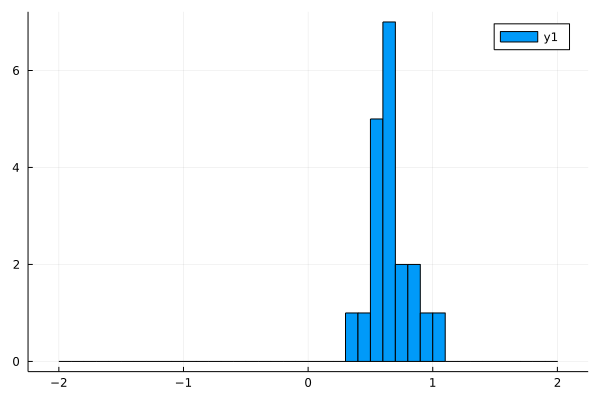

In [353]:
histogram(Gamma[:,1], bins = -2:0.1:2)

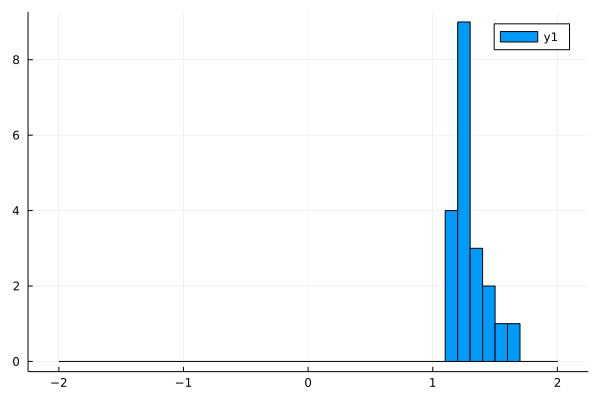

In [352]:
histogram(Gamma[:,2], bins = -2:0.1:2)

In [354]:
ma = mean(Alpha, dims = 1)

1×2 Matrix{Float64}:
 0.899127  0.436673

In [355]:
mb = mean(Beta, dims = 1)

1×2 Matrix{Float64}:
 2.39087  0.556366

In [356]:
mt = mean(Theta, dims = 1)

1×2 Matrix{Float64}:
 0.972089  -2.0004

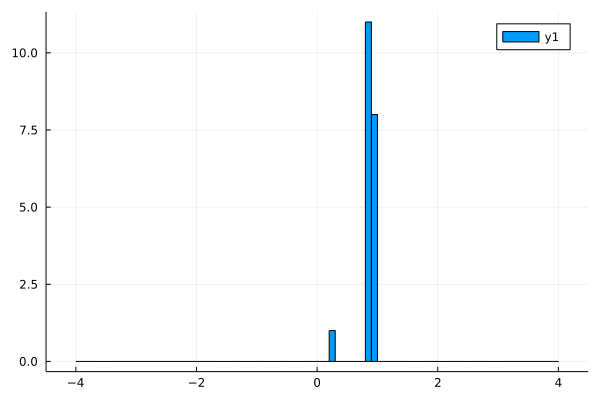

In [345]:
histogram(Alpha[:,1], bins = -4:0.1:4)

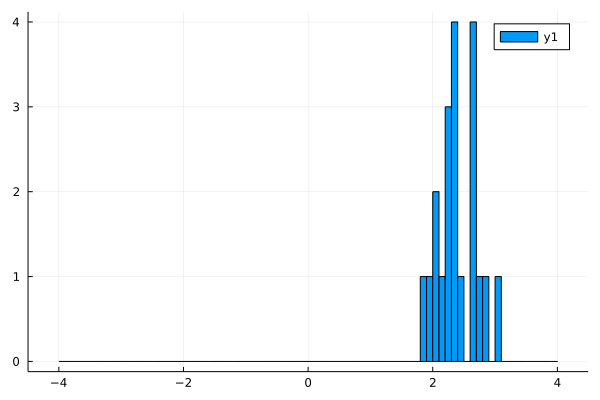

In [358]:
histogram(Beta[:,1], bins = -4:0.1:4)